In [1167]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gamma

In [1168]:
# import the csv file
data = pd.read_csv('IncPeriodData.csv')

In [1169]:
# show head of the csv file
data.head()

,IncPeriod
0,0.624314
1,9.814797
2,4.975259
3,2.687350
4,11.322319


array([[<Axes: title={'center': 'IncPeriod'}>]], dtype=object)

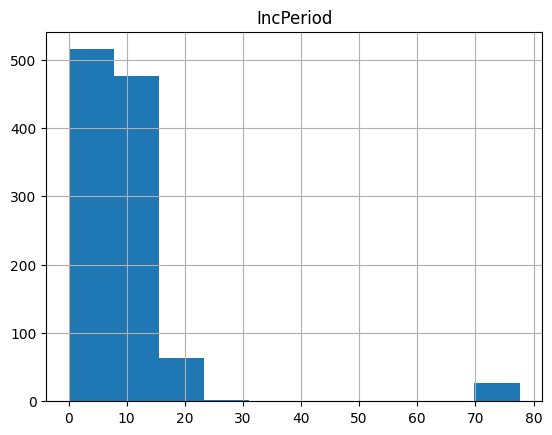

In [1170]:
# histogram of data
# you can use the pandas method dataframe.hist(bins=nmbr_bins)
# specify appropriate number of bins

data.hist()



# Data Cleaning

In [1171]:
# drop the lines from the DataFrame that exceed a certain value
# see method: dataframe.drop(datataframe[dataframe.column > value].index, inplace=True)

data.drop(data[data.IncPeriod>50].index, inplace=True)


array([[<Axes: title={'center': 'IncPeriod'}>]], dtype=object)

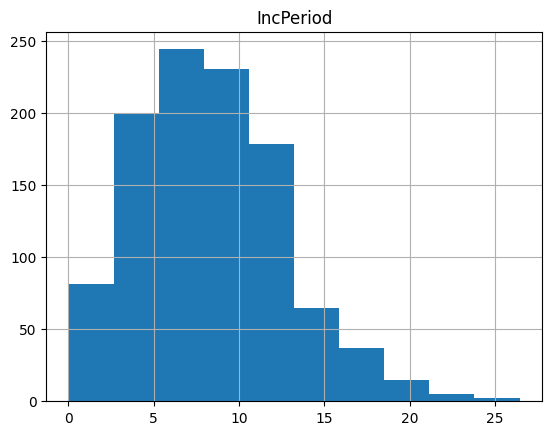

In [1172]:
# check again histogram of data
data.hist()

In [1173]:
# print mean, median, std of sample
# use again the pandas functions: dataframe.mean(), ...
print(f'sample mean:\n {data.mean()}\n\
        sample median:\n {data.median()}\n\
        sample standard deviation:\n {data.std()}')

sample mean:
 IncPeriod    8.334871
dtype: float64
        sample median:
 IncPeriod    7.986201
dtype: float64
        sample standard deviation:
 IncPeriod    4.285422
dtype: float64


# Kernel Density Estimation

In [1174]:
# you can use KernelDensity(kernel=kernel, bandwidth=value)
# create instance from kernel density estimator, specify kernel and bandwith
# see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity.sample

# Build model
gaussianModel= KernelDensity(kernel="gaussian")

In [1175]:
# fit the kernel density estimator: instance.fit([...])
# attention: the fit() function wants a shape [nmbr_samples, nmbr_features] array
# -- > best reshape your data, e.g. with np.array(data.IncPeriod).reshape(-1,1)

# make data vertical and numpy
verticalData = np.array(data.IncPeriod)[:, np.newaxis]
# fit model to data
gaussianModel = gaussianModel.fit(verticalData)

Text(0, 0.5, 'Number of occurencens')

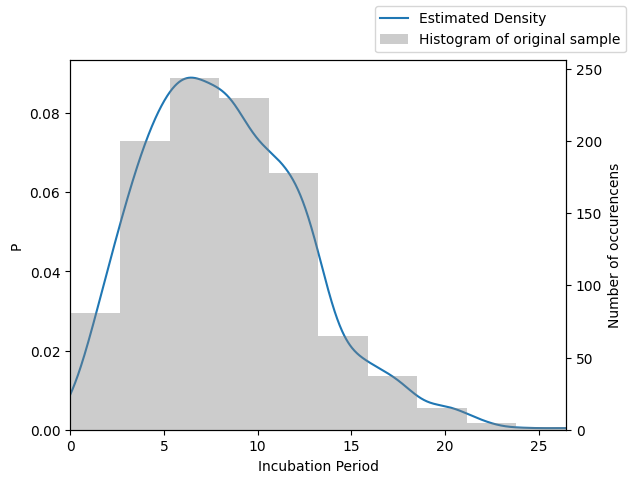

In [1176]:
# plot the kernel density probability distribution function: 
# instance.score_samples() returns the log-pdf (i.e. you still need to apply np.exp(...))
# attention: the score_samples() function also wants a shape [nmbr_samples, nmbr_features] array
# -- > best reshape your x-value grid, e.g. with np.array(x).reshape(-1,1) or x = np.linspace(0,max_val)[:, np.newaxis]


# make Omega with resolution res (again vertical)
res = 1000
x = np.linspace(0,np.array(data.IncPeriod).max(), res)[:,np.newaxis]
# estimate likelyhood
d = np.exp(gaussianModel.score_samples(x))
# plot
fig, ax = plt.subplots()
ax.plot(x,d)
# make ax nice
ax.set_xlim(x.min(),x.max())
ax.set_ylim(0,)
# add hist
hax = ax.twinx()
hax.hist(verticalData, color="grey", alpha=0.4)
# add descriptions
fig.legend(["Estimated Density", "Histogram of original sample"])
ax.set_ylabel("dP")
ax.set_xlabel("Incubation Period")
hax.set_ylabel("Number of occurencens")

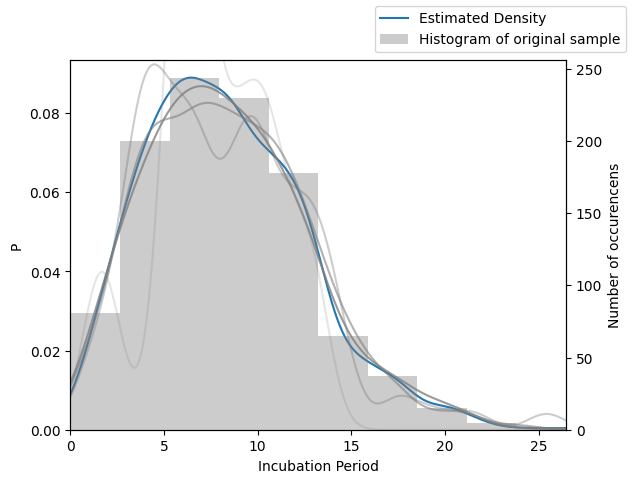

In [1177]:
# generate samples from estimated density function:
# instance.sample(sample_size) returns a sample of size sample_size
# then create new instance of KernelDensity, fit to the sample and plot again the pdf
logN = 5
for n in range(logN):
    sample = gaussianModel.sample(10**n)
    recModel = KernelDensity(kernel="gaussian")
    recModel.fit(sample)
    recd = np.exp(recModel.score_samples(x))
    ax.plot(x,recd, color="grey", alpha = n/logN)
fig




In [1178]:
# define the new probability density function as a function
# you probabily want to use the scipy.stats.gamma.pdf(x,a=4) function

def folded_pdf(x):
    """Gets an x-grid and returns the folded probability distribution

    Parameters
    ----------
    x : numpy array of shape (N,1)
        The x-grid on which the probability densitiy function is evaluated

    Returns
    -------
    numpy array of shape (N,1)
        The resulting, folded pdf
    """

    # the gamma distribution
    g = gamma.pdf(x, a=4)[:,0]
    # the pdf of the kernel density estimation
    p = d
    # convolve
    c = np.convolve(g,p)*(x.max()-x.min())/len(x)
    # truncate the result for same length with grid
    c = c[:len(x)]
    
    return c

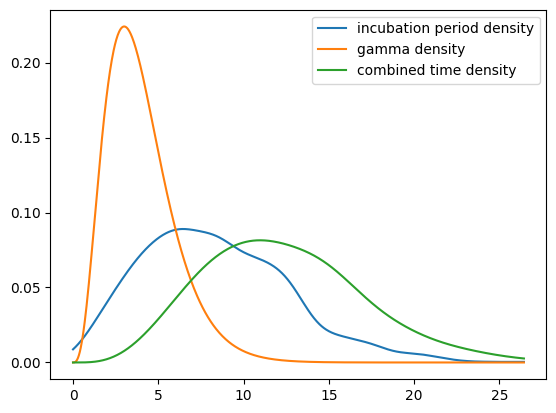

In [1179]:
# plot the folded pdf

t = folded_pdf(x)
fig, ax = plt.subplots()
ax.plot(x,d)
ax.plot(x,gamma.pdf(x, a=4))
ax.plot(x,t)
ax.legend(["incubation period density","gamma density","combined density"])
ax.set_ylabel("dP")
ax.set_xlabel("Incubation Period + Calling wait time")